# **Import necessary libraries**

In [2]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# **Data preparing and Preprocessing**

# *Create Dataframe*

In [3]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


# *Map CT sacn and corresponding segmenation mask*

In [4]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,../input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


# *The function for reading .nii files and returning pixel arrays*

In [5]:
def read_nii(filepath):

    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [31]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


# *Define windowed function*

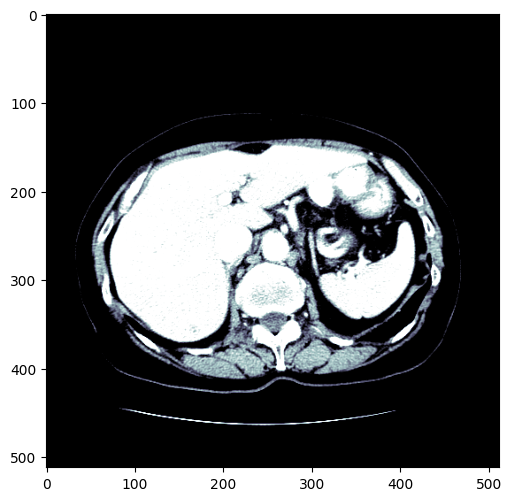

In [35]:
# Preprocess the nii file 

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 60].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# *Plota a sample CT image and the mask*

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):

    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('on')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('on')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('on')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('on')
    
    plt.show()

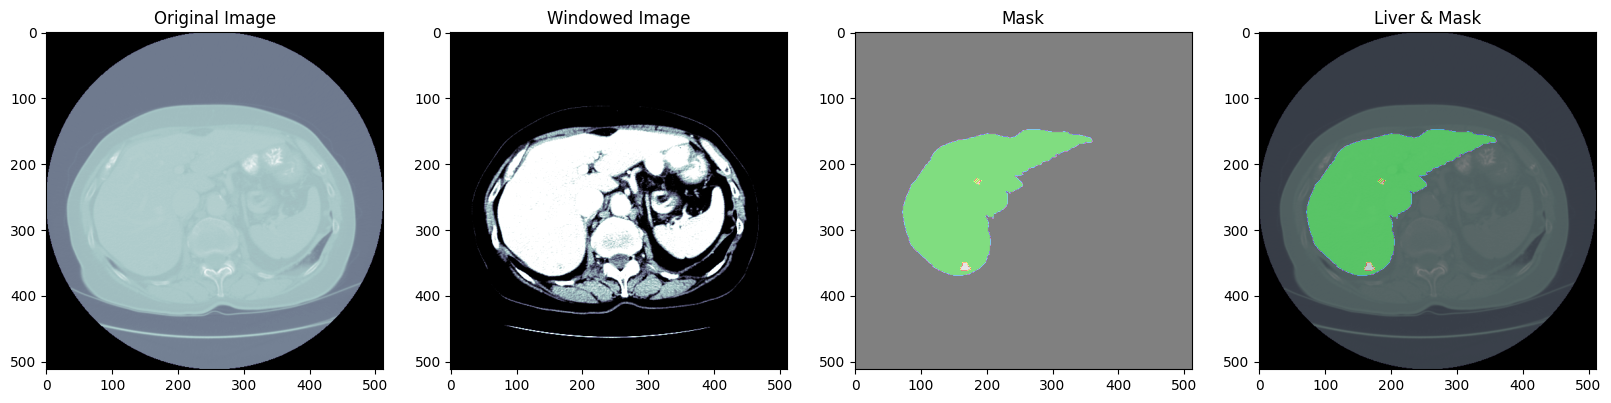

In [36]:
sample = 60

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

# *The function for converting a image array to JPG*

<AxesSubplot:>

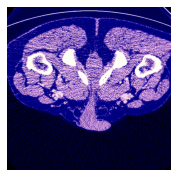

In [12]:
@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

# *Make custom JPG files for Unet training*

In [13]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


# **3- Model Training**

# *Preparing Data for Training*

In [56]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/'train_images')

(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)


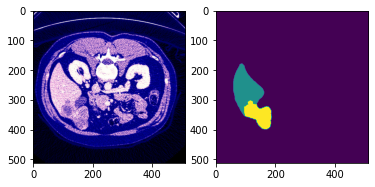

In [57]:
print((ds[20]))
idx = 20
imgs = [ds[idx][0],ds[idx][1]]
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('on')
    ax.imshow(imgs[i])

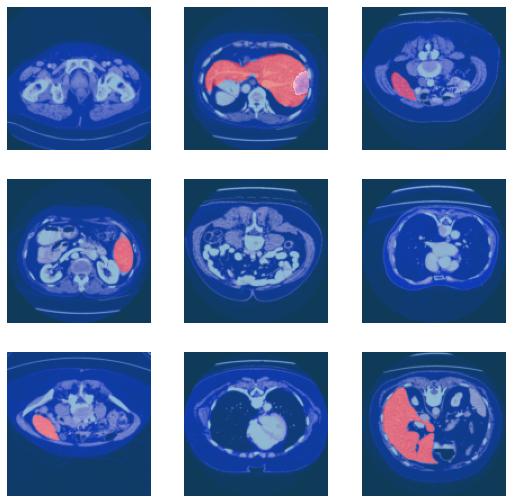

In [62]:
dls = db.dataloaders(path/'train_images', bs = BATCH_SIZE) 
dls.show_batch()

# *Define Custom Accuracy Functions*

In [18]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

# *Create the Learner using ResNet34 backbone*

In [19]:
learn = unet_learner(dls,
                     resnet34,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc]) 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
learn.fine_tune(4, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.013532,0.012381,0.926334,0.995744,01:24


Better model found at epoch 0 with valid_loss value: 0.012380573898553848.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.008274,0.007176,0.949223,0.997571,01:21
1,0.004793,0.005371,0.942346,0.998231,01:21
2,0.003148,0.003503,0.968267,0.998637,01:22
3,0.003037,0.003170,0.966959,0.998761,01:21


Better model found at epoch 0 with valid_loss value: 0.007176441140472889.
Better model found at epoch 1 with valid_loss value: 0.005371064879000187.
Better model found at epoch 2 with valid_loss value: 0.003503182204440236.
Better model found at epoch 3 with valid_loss value: 0.0031699533574283123.


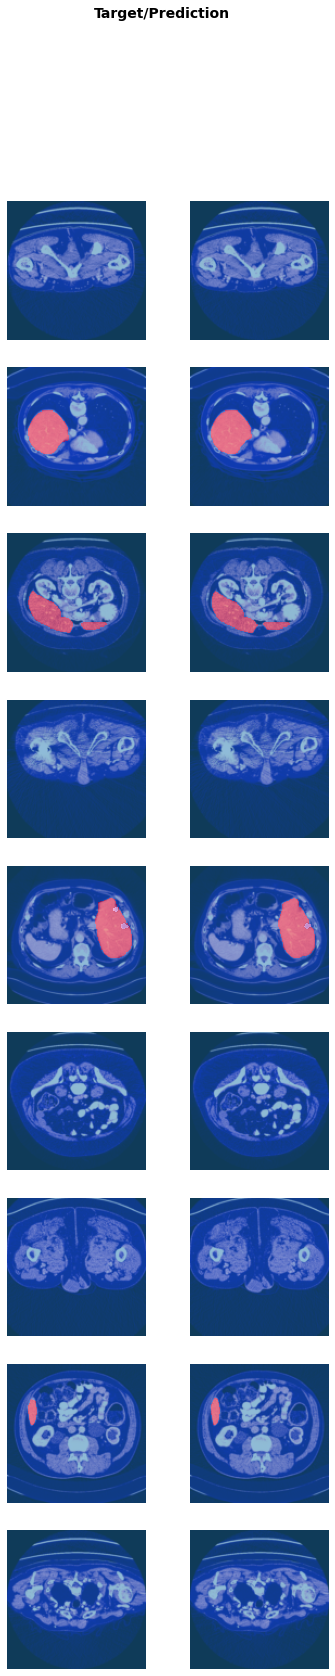

In [21]:
learn.show_results()

In [22]:
# Save the model
learn.export(path/f'Liver_segmentation')

# **Testing the Model**

In [23]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(),Normalize()]
    learn0 = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

# *Preparing .nii files for prediction*

In [24]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

(512, 512, 846)


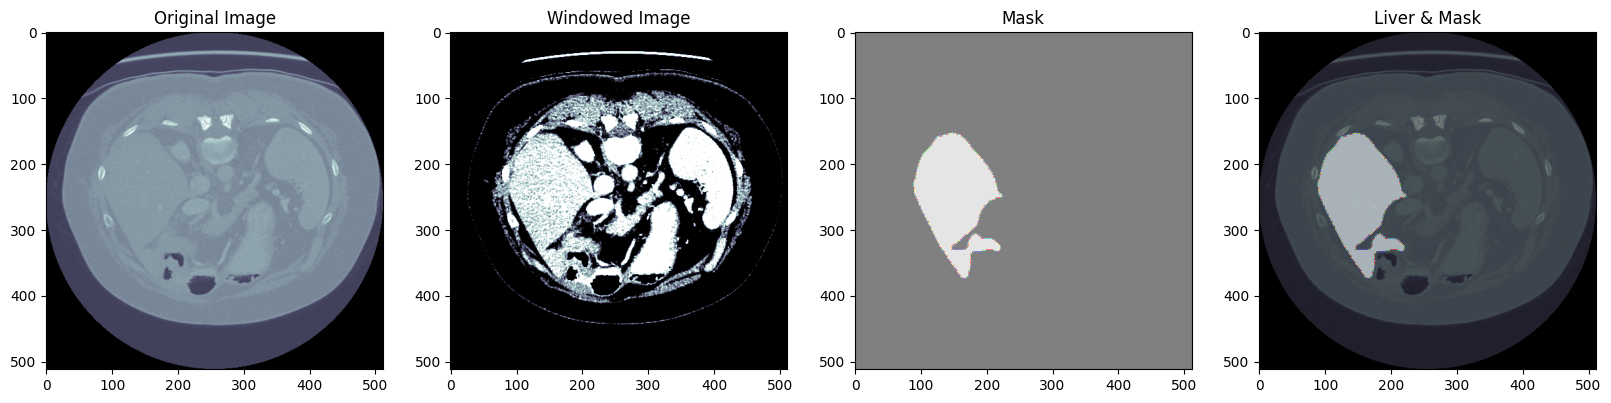

In [25]:
tst = 18

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 450

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [26]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ", len(test_files))

Number of test slices:  846


<AxesSubplot:>

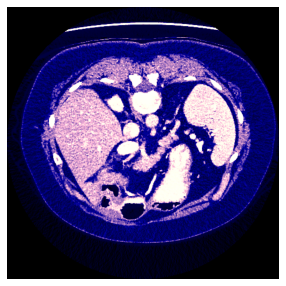

In [27]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

# *Get prediction*

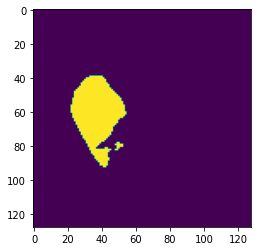

In [28]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)

plt.imshow(predicted_mask[test_slice_idx])

# *Getting predictions done on multiple images*


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0 1]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0 1]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1 2]
actual: [0 1 2]


curr slice: 420
predicted [0 1]
actual: [0 1 2]


curr slice: 430
predicted [0 1 2]
actual: [0 1 2]


curr slice: 440
predicted [0 1 2]
actual: [0 1 2]


curr slice: 450
predicted [0 1 2]
actual: [0 1 2]


curr slice: 460
predicted [0 1 2]
actual: [0 1 2]


curr slice: 470
predicted [0 1 2]
actual: [0 1 2]


curr slice: 480
predicted [0 1 2]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1 2]


curr slice: 540
predicted [0 1 2]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1 2]
actual: [0 1 2]


curr slice: 420
predicted [0 1 2]
actual: [0 1 2]


curr slice: 430
predicted [0 1 2]
actual: [0 1 2]


curr slice: 440
predicted [0 1 2]
actual: [0 1 2]


curr slice: 450
predicted [0 1 2]
actual: [0 1 2]


curr slice: 460
predicted [0 1 2]
actual: [0 1 2]


curr slice: 470
predicted [0 1 2]
actual: [0 1 2]


curr slice: 480
predicted [0 1 2]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1 2]


curr slice: 540
predicted [0 1 2]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0 1]


curr slice: 390
predicted [0 1]
actual: [0 1]


curr slice: 400
predicted [0 1]
actual: [0 1]


curr slice: 410
predicted [0 1]
actual: [0 1]


curr slice: 420
predicted [0 1]
actual: [0 1]


curr slice: 430
predicted [0 1]
actual: [0 1]


curr slice: 440
predicted [0 1]
actual: [0 1]


curr slice: 450
predicted [0 1]
actual: [0 1]


curr slice: 460
predicted [0 1]
actual: [0 1]


curr slice: 470
predicted [0 1]
actual: [0 1]


curr slice: 480
predicted [0 1]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1 2]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1]
actual: [0 1 2]


curr slice: 530
predicted [0 1]
actual: [0 1]


curr slice: 540
predicted [0 1]
actual: [0 1]


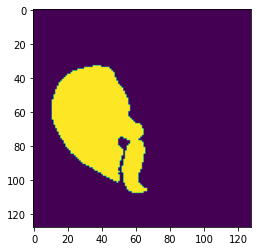

In [66]:
def nii_tfm_selctive(fn,wins,curr_slice): 
    slices = []
    test_nii  = read_nii(fn)
    data = tensor(test_nii[...,curr_slice].astype(np.float32))
    data = (data.to_nchan(wins)*255).byte()
    slices.append(TensorImage(data))
    return slices

def check(img):
    cnt,h = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) > 0:
        return 1
    else:
        return 0
    

nums = [3,4,5]
vol_names = ['volume-100.nii','volume-102.nii','volume-102.nii']
seg_names = ['segmentation-100.nii','segmentation-102.nii','segmentation-102.nii']


conf_matrix =  np.zeros((2,2),dtype = int)


for nums,vol_names,seg_names in zip(nums,vol_names,seg_names):
    curr_mask      = read_nii(df_files.loc[nums,'mask_dirname']+"/"+df_files.loc[nums,'mask_filename'])
    for curr_slice in tqdm(range(250,550,10)): # export every 10th slice for testing
        
        # for prediction
        test_file = nii_tfm_selctive(df_files.loc[nums,'dirname']+"/"+df_files.loc[nums,'filename'],[dicom_windows.liver, dicom_windows.custom],curr_slice)
        test_dl = learn0.dls.test_dl(test_file)
        preds, y = learn0.get_preds(dl=test_dl)
        
        predicted_mask = np.argmax(preds, axis=1)# getting the predicted mask
        plt.imshow(predicted_mask[0])
        a=np.array(predicted_mask[0])
        
        tumor_p = False
        
        print('curr slice:',curr_slice)
        
        unique = np.unique(a)
        print("predicted",unique)
        if 0 in unique:
            back_p = True
        else:
            back_p = False
        if 1 in unique:
            liver_p = True
        else:
            liver_p = False
        if 2 in unique:
            tumor_p = True
        else:
            tumor_p = False
        

        # for getiing the actual mask values
        mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
        tumor_t = False
        
        unique = np.unique(mask)
        print("actual:",unique)
        if 0 in unique:
            back_t = True
        else:
            back_t = False
        if 1 in unique:
            liver_t = True
        else:
            liver_t = False
        if 2 in unique:
            tumor_t = True
        else:
            tumor_t = False
            
        # populating the conf_matrix
        if tumor_p == True and tumor_t == True:
            conf_matrix[0,0] += 1
        if tumor_p == False and tumor_t == False:
            conf_matrix[1,1] += 1
        if tumor_p == False and tumor_t == True:
            conf_matrix[1,0] += 1
        if tumor_p == True and tumor_t == False:
            conf_matrix[0,1] += 1
            
        
# print(conf_matrix)

# *Plot Confusion Matrix*

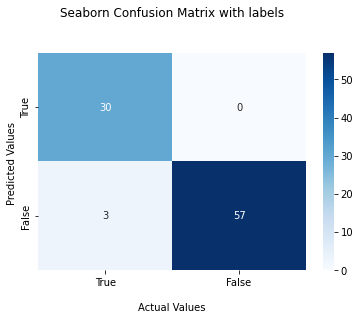

In [67]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

plt.show()